In [100]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from matplotlib.colors import LogNorm
from scipy.interpolate import make_smoothing_spline

def my_fit_left(x, y, n_x_grids=100, xc_min=None, xc_max=None, tail_length=None, min_points=10):
    if xc_min is None:
        xc_min = x.max() * 0.9
    if xc_max is None:
        xc_max = x.max() * 1.1
    if tail_length is None:
        tail_length = x.size

    x_grid = np.linspace(xc_min, xc_max, n_x_grids)

    errors = []
    for xc in x_grid:
        delta = np.log10(xc - x)
        f = np.log10(y)
        mask = ~(np.isnan(f) | np.isnan(delta))
        if np.sum(mask) < min_points:
            sse = np.inf
        else:
            m, b = np.polyfit(delta[mask], f[mask], 1)
            sse = np.sum((m * delta[mask][:tail_length] + b - f[mask][:tail_length]) ** 2)
        errors.append(sse)

    xc = x_grid[np.argmin(errors)]
    delta = np.log10(xc - x)
    f = np.log10(y)
    mask = ~(np.isnan(f) | np.isnan(delta))
    m, b = np.polyfit(delta[mask], f[mask], 1)

    return {
        'xc': xc,
        'sse': min(errors),
        'A': 10 ** b,
        'n': m
    }

In [38]:
root = '/Users/marshallmccraw/Projects/yale/data/s-25/10-02-25/grace-data/rb-compression-diffusion-lower-temp'
all_data = {
    'nv': [],
    'mu_eff': [],
    'mean_pressure': [],
    'phi': []
}
for dirpath, dirnames, filenames in os.walk(root):
    if 'pressure' not in os.path.basename(dirpath):
        continue
    data = dp.data.load(dirpath, location=['final', 'init'])
    if 'mean_pressure' not in data.final.arrays.keys():
        continue
    data.calculate_mu_eff()
    all_data['nv'].extend(data.n_vertices_per_particle[data.system_offset[:-1]])
    all_data['mu_eff'].extend(data.mu_eff[data.system_offset[:-1]])
    all_data['mean_pressure'].extend(data.mean_pressure)
    all_data['phi'].extend(data.packing_fraction)
all_data = pd.DataFrame(all_data)

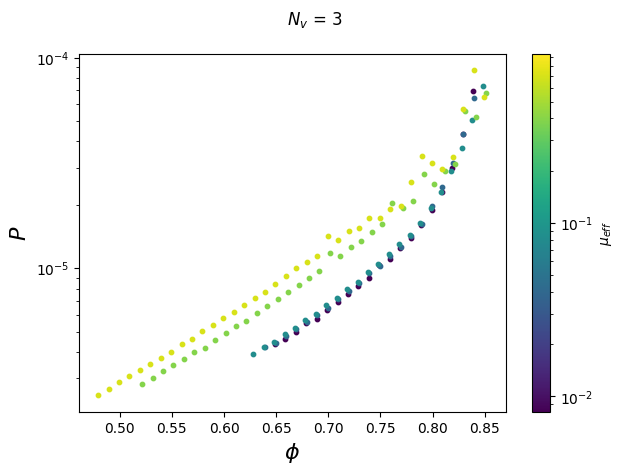

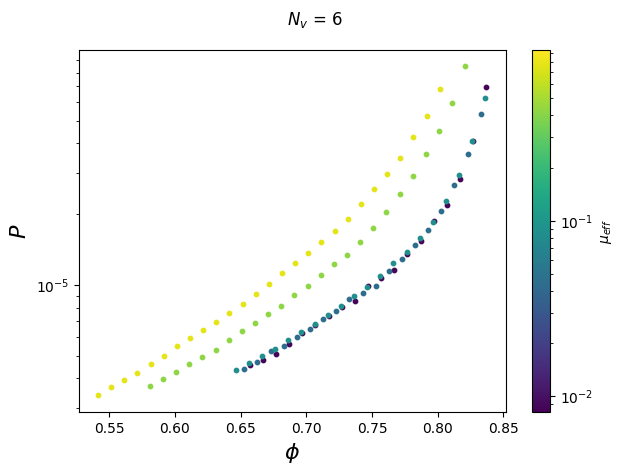

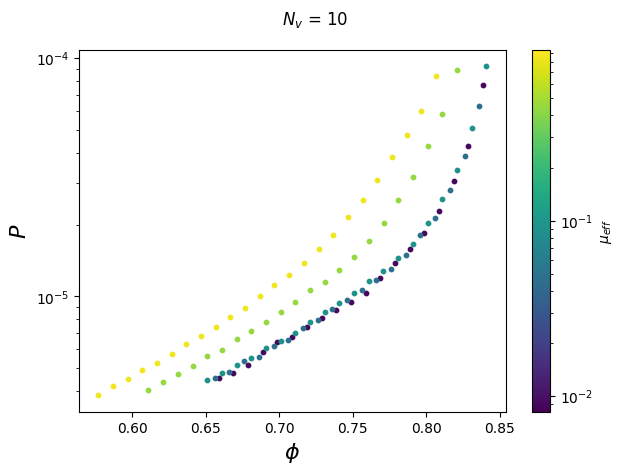

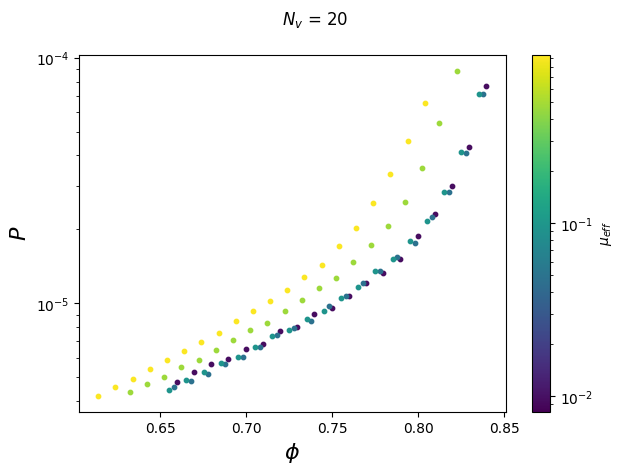

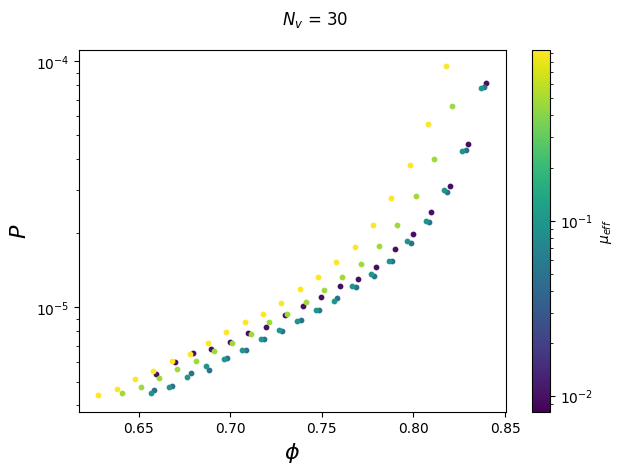

In [96]:
mu_norm = LogNorm(vmin=all_data.mu_eff.min(), vmax=all_data.mu_eff.max())
cmap = plt.cm.viridis

p_max = 1e-3
p_max = 1e-4

for nv in np.unique(all_data.nv):
    for mu in np.unique(all_data[all_data.nv == nv].mu_eff):
        df = all_data[(all_data.nv == nv) & (all_data.mu_eff == mu)]
        x = df.phi.values
        y = df.mean_pressure.values
        y = y[np.argsort(x)]
        x = x[np.argsort(x)]
        x = x[y < p_max]
        y = y[y < p_max]

        plt.scatter(x, y, color=cmap(mu_norm(mu)), s=10)
    plt.yscale('log')
    plt.xlabel(r'$\phi$', fontsize=16)
    plt.ylabel(r'$P$', fontsize=16)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(all_data.mu_eff.values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.tight_layout()
    plt.savefig(f'pressure-figures/raw/NV-{nv}.png', dpi=600)
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_31717/1354574501.py:22: RuntimeWarning: invalid value encountered in log10
  delta = np.log10(xc - x)


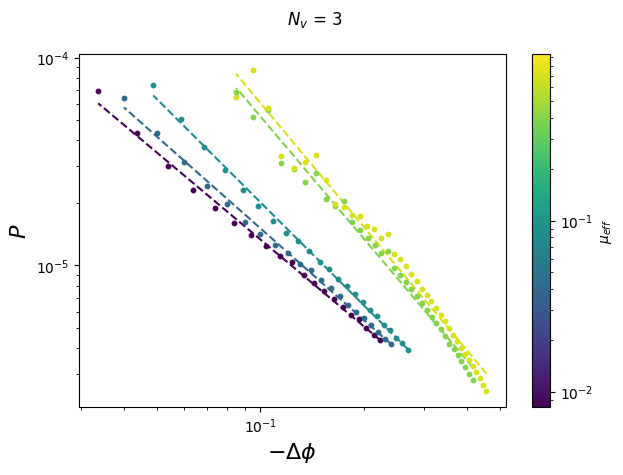

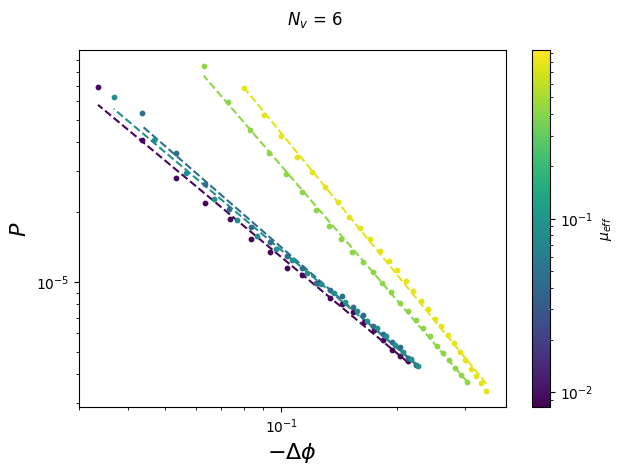

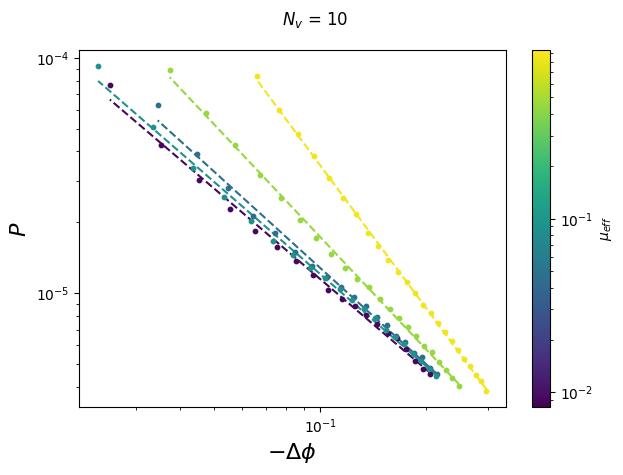

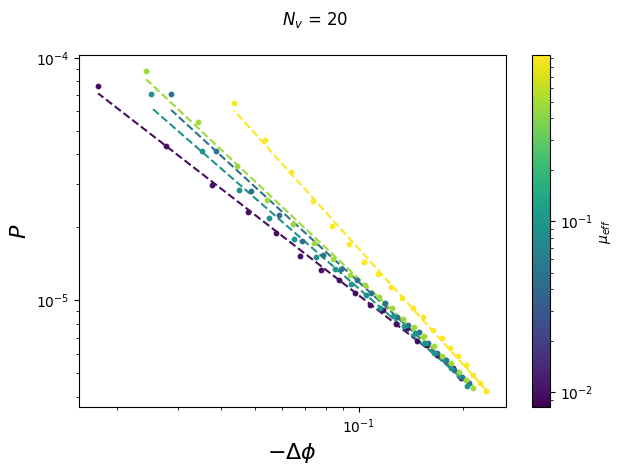

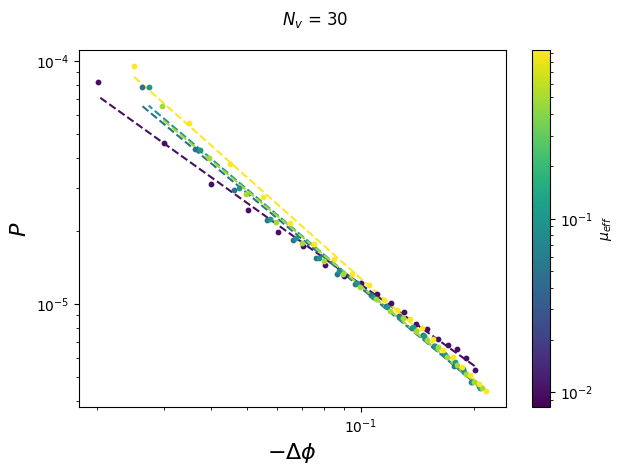

In [97]:
mu_norm = LogNorm(vmin=all_data.mu_eff.min(), vmax=all_data.mu_eff.max())
cmap = plt.cm.viridis

p_max = 1e-3
p_max = 1e-4

fit_data = {
    'nv': [],
    'mu': [],
    'P0': [],
    'phi_c': [],
    'n': []
}

for nv in np.unique(all_data.nv):
    for mu in np.unique(all_data[all_data.nv == nv].mu_eff):
        df = all_data[(all_data.nv == nv) & (all_data.mu_eff == mu)]
        x = df.phi.values
        y = df.mean_pressure.values
        y = y[np.argsort(x)]
        x = x[np.argsort(x)]
        x = x[y < p_max]
        y = y[y < p_max]

        fit = my_fit_left(x, y, 1000, xc_min=0.98 * x.max(), xc_max=1.1 * x.max(), tail_length=10, min_points=10)
        y_pred = fit['A'] * np.abs(fit['xc'] - x) ** fit['n']

        fit_data['nv'].append(nv)
        fit_data['mu'].append(mu)
        fit_data['P0'].append(fit['A'])
        fit_data['phi_c'].append(fit['xc'])
        fit_data['n'].append(fit['n'])

        plt.plot(fit['xc'] - x, y_pred, c=cmap(mu_norm(mu)), linestyle='--', zorder=0)
        plt.scatter(fit['xc'] - x, y, color=cmap(mu_norm(mu)), s=10)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(r'$-\Delta \phi$', fontsize=16)
    plt.ylabel(r'$P$', fontsize=16)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(all_data.mu_eff.values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.tight_layout()
    plt.savefig(f'pressure-figures/fits/NV-{nv}.png', dpi=600)
    plt.show()

fit_data = pd.DataFrame(fit_data)

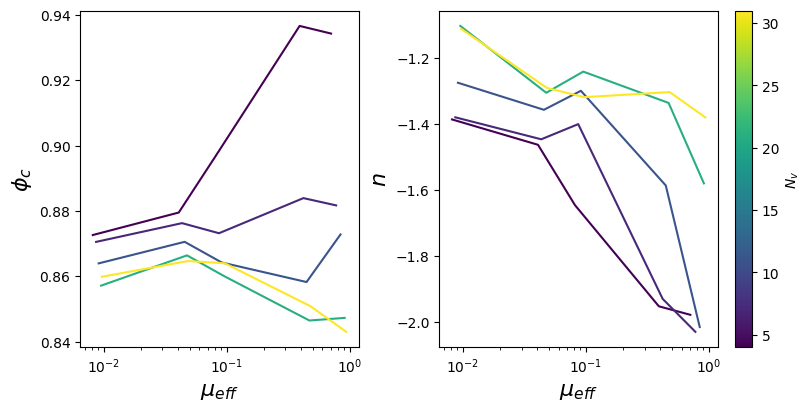

In [98]:
nv_norm = plt.Normalize(vmin=fit_data.nv.min(), vmax=fit_data.nv.max())

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
for nv in np.unique(fit_data.nv):
    df = fit_data[fit_data.nv == nv]
    ax[0].plot(df.mu, df.phi_c, c=cmap(nv_norm(nv)))
    ax[1].plot(df.mu, df.n, c=cmap(nv_norm(nv)))
for a in ax:
    a.set_xscale('log')
    a.set_xlabel(r'$\mu_{eff}$', fontsize=16)
ax[0].set_ylabel(r'$\phi_c$', fontsize=16)
ax[1].set_ylabel(r'$n$', fontsize=16)
sm = plt.cm.ScalarMappable(norm=nv_norm, cmap=cmap)
sm.set_array(fit_data.nv.values)
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$N_v$')
plt.savefig('pressure-figures/fit-params.png', dpi=600)

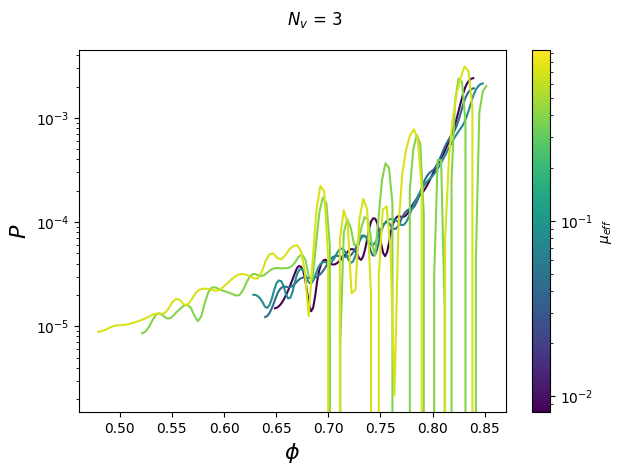

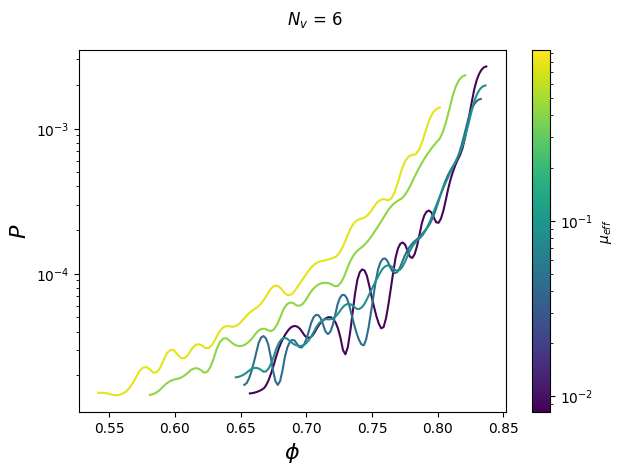

In [ ]:

for nv in np.unique(all_data.nv):
    for mu in np.unique(all_data[all_data.nv == nv].mu_eff):
        df = all_data[(all_data.nv == nv) & (all_data.mu_eff == mu)]
        x = df.phi.values
        y = df.mean_pressure.values
        y = y[np.argsort(x)]
        x = x[np.argsort(x)]
        x = x[y < p_max]
        y = y[y < p_max]

        x_fit = np.linspace(min(x), max(x), 100)
        spline = make_smoothing_spline(x, y, lam=1e-9)
        y_fit = spline(x_fit)
        # plt.plot(x_fit, y_fit)
        slope = spline(x_fit, nu=1)
        plt.plot(x_fit, slope * x_fit, color=cmap(mu_norm(mu)))

        # plt.scatter(x, y, color=cmap(mu_norm(mu)), s=10)
    plt.yscale('log')
    plt.xlabel(r'$\phi$', fontsize=16)
    plt.ylabel(r'$P$', fontsize=16)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(all_data.mu_eff.values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.tight_layout()
    plt.show()